# Domain A - Cracks

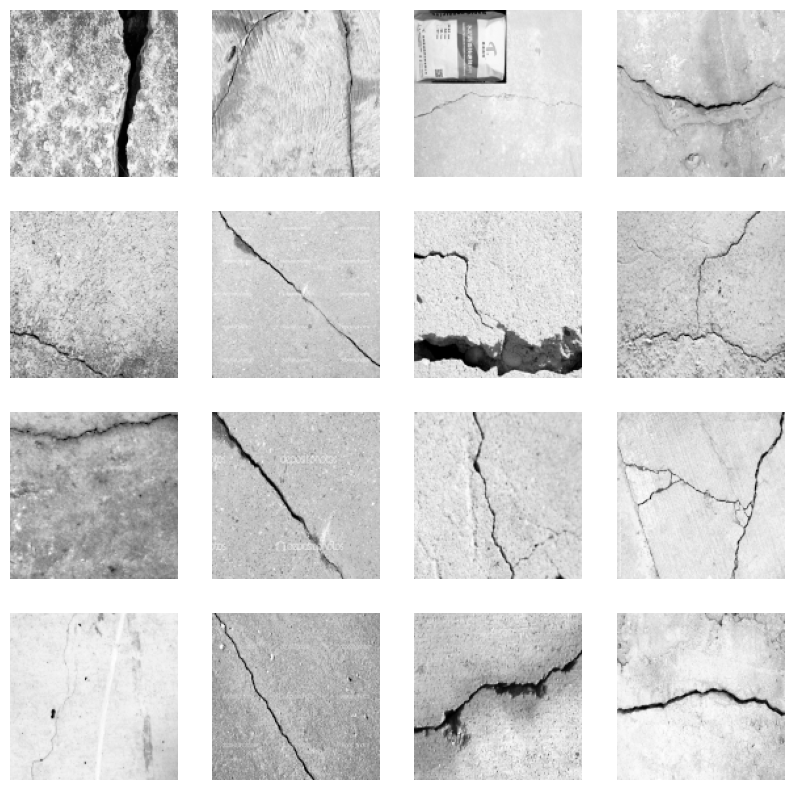

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

filenames = glob('crack_segmentation_dataset/images/DeepCrack*.jpg')
y_filenames = glob('crack_segmentation_dataset/masks/CFD*.jpg')
plt.figure(figsize=(10, 10))
for i in range(16):
    X = np.random.choice(filenames)
    img = cv2.imread(X, -1)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    img = 255-cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.subplot(4,4,i+1)
    plt.axis(False)
    plt.imshow(img, cmap='Greys')
plt.show()

# Domain B - Fake Cracks

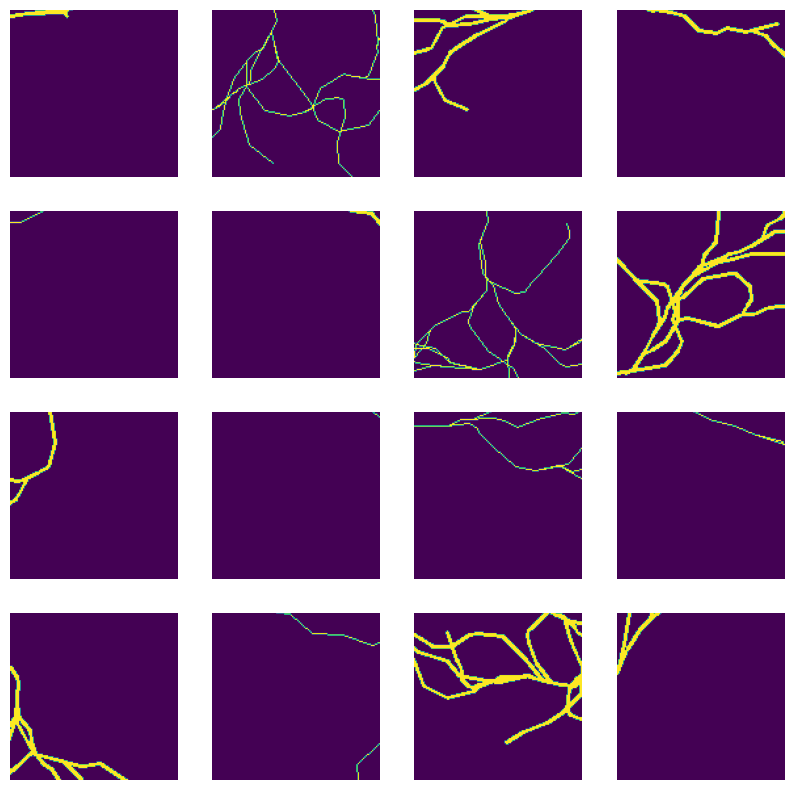

In [2]:
import importlib
import cyclegan
cyclegan = importlib.reload(cyclegan)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    crack = cyclegan.DataGenerator([],[], 128, 128).generate_crack()
    plt.axis(False)

    plt.imshow(crack)
plt.show()

# Instantiate CycleGAN model

In [3]:
import importlib
import cyclegan
cyclegan = importlib.reload(cyclegan)

filenames = glob('crack_segmentation_dataset/images/DeepCrack*.jpg')
y_filenames = glob('crack_segmentation_dataset/masks/CFD*.jpg')

cyclegan_model = cyclegan.CycleGAN(128, 128)
cyclegan_model.data_generator = cyclegan.DataGenerator(filenames,y_filenames, 128, 128)

In [4]:
cyclegan_model.c_model_AB.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128, 128, 1)  73762819    ['input_5[0][0]',                
                                                                  'input_6[0][0]',                
                                                                  'model_1[1][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                         

In [5]:
from tensorflow.keras.models import load_model

cyclegan_model.g_model_AB = load_model('initial_models2/g_model_AB.h5')
cyclegan_model.g_model_BA = load_model('initial_models2/g_model_BA.h5')

In [6]:
def normalise_image(img):

    return ((img - np.amin(img)) / (np.amax(img) - np.amin(img)))*2-1

# A 2 B Example

1/1 [==============================] - 0s 22ms/step


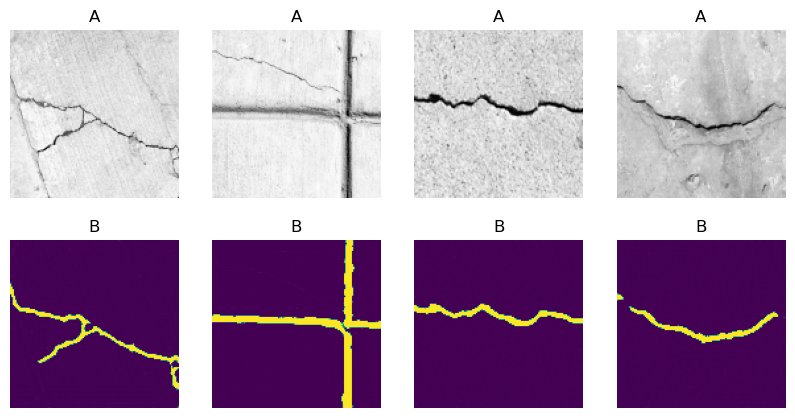

In [7]:
plt.figure(figsize=(10, 5))
for i in range(4):

    X = np.random.choice(filenames)
    img = cv2.imread(X, -1)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    img = 255-cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pred = cyclegan_model.g_model_AB.predict(np.expand_dims(normalise_image(img), axis=[0, -1]))

    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap='Greys')
    plt.title('A')
    plt.axis(False)
    plt.subplot(2,4,i+4+1)
    plt.imshow(np.squeeze(pred))
    plt.title('B')
    plt.axis(False)
plt.show()

# B 2 A Example

1/1 [==============================] - 0s 22ms/step


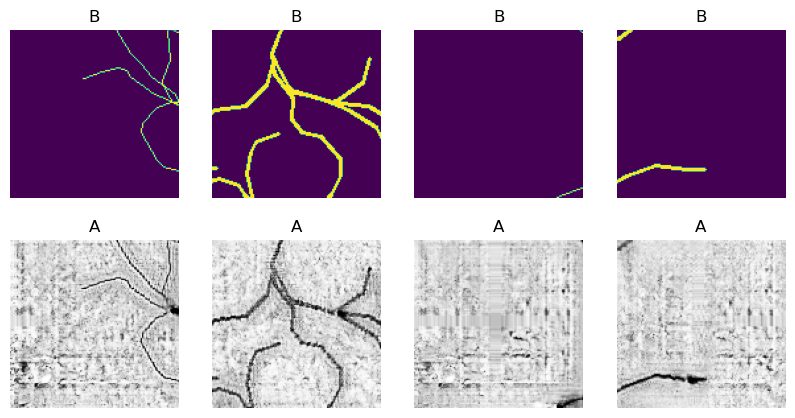

In [8]:
plt.figure(figsize=(10, 5))
for i in range(4):
    crack = cyclegan_model.data_generator.generate_crack()
    plt.subplot(2, 4, i+1)
    plt.imshow(np.squeeze(crack))
    plt.title('B')
    plt.axis(False)

    pred_BA = cyclegan_model.g_model_BA.predict(np.expand_dims(normalise_image(crack), axis=[0, -1]))

    plt.subplot(2, 4, i+4+1)
    plt.title('A')
    plt.imshow(np.squeeze(pred_BA), cmap='Greys')
    plt.axis(False)
plt.show()

In [ ]:
import gradio as gr

def function(img):
    print('image received')
    print(type(img))
    print(np.shape(img))
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    img = ((img - np.amin(img)) / (np.amax(img) - np.amin(img)))*2-1
    img = np.expand_dims(img, axis=[0, -1])
    pred_BA = cyclegan_model.g_model_BA.predict(img)
    pred_BA = np.squeeze(pred_BA)

    pred_BA = (pred_BA - np.amin(pred_BA)) / (np.amax(pred_BA) - np.amin(pred_BA))

    return pred_BA

gr.Interface(fn=function, 
             inputs=cp,
             outputs=gr.outputs.Image(type="numpy", label="Output"),
             live=True).launch()


In [ ]:
gr.Sketchpad(kwargs={'shape':(128, 128)})

In [ ]:
sp = gr.Sketchpad()
sp.shape = (1024, 1024)

In [ ]:
cp = gr.Image(tool='color-sketch', source='canvas', image_mode='L')
cp.shape = (128, 128)

In [ ]:
output_image = gr.Image(image_mode='L', shape=(128, 128))